Imports

In [198]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Loading The Dataset

In [199]:
file_path = 'CrossCheck_Daily_Data.xlsx'  
data = pd.read_excel(file_path)

print("Dataset Shape:", data.shape)
print("Column Names:", data.columns)
print(data.head())

Dataset Shape: (23573, 155)
Column Names: Index(['study_id', 'eureka_id', 'day', 'act_in_vehicle_ep_0',
       'act_in_vehicle_ep_1', 'act_in_vehicle_ep_2', 'act_in_vehicle_ep_3',
       'act_in_vehicle_ep_4', 'act_on_bike_ep_0', 'act_on_bike_ep_1',
       ...
       'unlock_duration_ep_0', 'unlock_duration_ep_1', 'unlock_duration_ep_2',
       'unlock_duration_ep_3', 'unlock_duration_ep_4', 'unlock_num_ep_0',
       'unlock_num_ep_1', 'unlock_num_ep_2', 'unlock_num_ep_3',
       'unlock_num_ep_4'],
      dtype='object', length=155)
   study_id eureka_id       day  act_in_vehicle_ep_0  act_in_vehicle_ep_1  \
0        -1      u004  20150122                    0                    0   
1        -1      u004  20150123                    0                    0   
2        -1      u004  20150124                    0                    0   
3        -1      u004  20150125                    0                    0   
4        -1      u004  20150126                    0                    0   

Data Cleaning

In [200]:
# Drop columns with more than 60% missing values
missing_threshold = 0.6* len(data)
data = data.loc[:, data.isnull().sum() <= missing_threshold]
print(f"Columns retained: {data.shape[1]}")

Columns retained: 141


In [201]:
#get all coulmns that have all data = zero and drop it 
nullCoulmns=data.columns[(data==0).all()]
data=data.drop(columns=nullCoulmns)

# eureka_id dropped because its redundant and duplicates the study id
data=data.drop(columns=['eureka_id'])

print(f"Dropped {len(nullCoulmns)} columns with only zero values.")
print(f"Columns retained: {data.shape[1]}")
print("Remaining columns:", data.columns)



Dropped 13 columns with only zero values.
Columns retained: 127
Remaining columns: Index(['study_id', 'day', 'act_in_vehicle_ep_0', 'act_in_vehicle_ep_1',
       'act_in_vehicle_ep_2', 'act_in_vehicle_ep_3', 'act_in_vehicle_ep_4',
       'act_on_bike_ep_0', 'act_on_bike_ep_1', 'act_on_bike_ep_2',
       ...
       'unlock_duration_ep_0', 'unlock_duration_ep_1', 'unlock_duration_ep_2',
       'unlock_duration_ep_3', 'unlock_duration_ep_4', 'unlock_num_ep_0',
       'unlock_num_ep_1', 'unlock_num_ep_2', 'unlock_num_ep_3',
       'unlock_num_ep_4'],
      dtype='object', length=127)


OUtliers Detection

Column 'study_id' has 0 outliers.
Column 'day' has 22 outliers.
Column 'act_in_vehicle_ep_0' has 2655 outliers.
Column 'act_in_vehicle_ep_1' has 3419 outliers.
Column 'act_in_vehicle_ep_2' has 4990 outliers.
Column 'act_in_vehicle_ep_3' has 3648 outliers.
Column 'act_in_vehicle_ep_4' has 4682 outliers.
Column 'act_on_bike_ep_0' has 4045 outliers.
Column 'act_on_bike_ep_1' has 958 outliers.
Column 'act_on_bike_ep_2' has 3234 outliers.
Column 'act_on_bike_ep_3' has 5306 outliers.
Column 'act_on_bike_ep_4' has 3499 outliers.
Column 'act_on_foot_ep_0' has 2984 outliers.
Column 'act_on_foot_ep_1' has 2256 outliers.
Column 'act_on_foot_ep_2' has 5370 outliers.
Column 'act_on_foot_ep_3' has 3786 outliers.
Column 'act_on_foot_ep_4' has 5129 outliers.
Column 'act_still_ep_0' has 1367 outliers.
Column 'act_still_ep_1' has 5002 outliers.
Column 'act_still_ep_2' has 3478 outliers.
Column 'act_still_ep_3' has 1484 outliers.
Column 'act_still_ep_4' has 2931 outliers.
Column 'act_tilting_ep_0' has 15

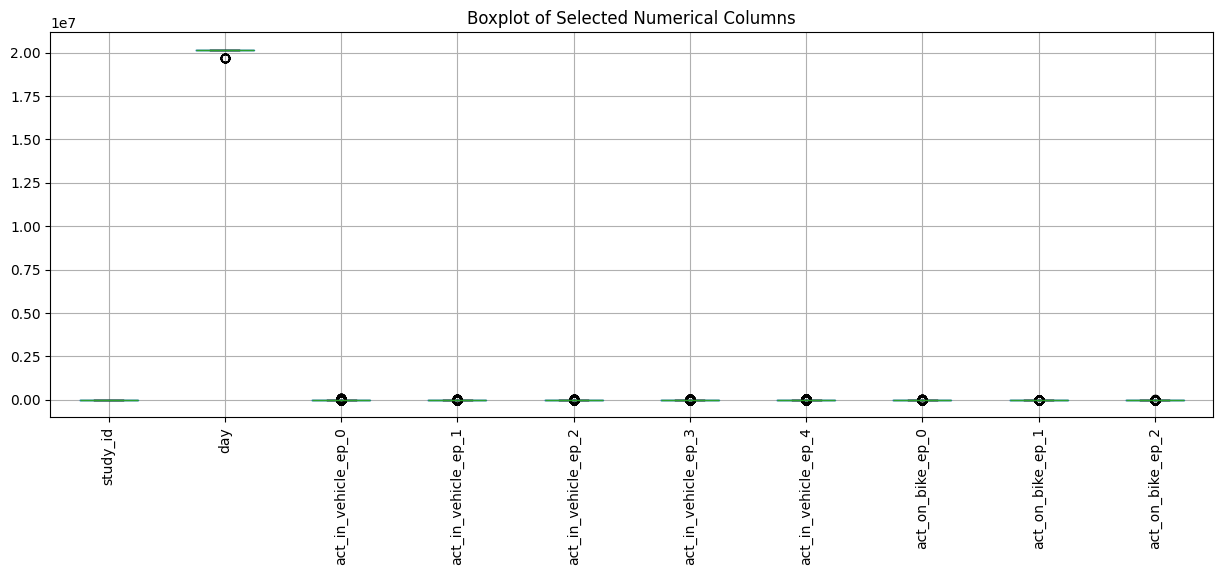

In [202]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

outliers = {}
#using IQR for detcting outliers 
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col].count()


for col, count in outliers.items():
    print(f"Column '{col}' has {count} outliers.")


subset = numerical_cols[:10] 
data[subset].boxplot(figsize=(15, 5), rot=90)
plt.title("Boxplot of Selected Numerical Columns")
plt.show()

In [203]:
#since there is alot of ouliers detected we will use the median to fill out the missing values
data = data.fillna(data.median(numeric_only=True))

missing_values = data.isnull().sum().sum()

print(f"All missing values have been filled. Total missing values remaining: {missing_values}")

All missing values have been filled. Total missing values remaining: 0


Data Aggregation

In [204]:
#Aggregate the eps to make it one full day

new_columns = []
processed_base_columns = set()  
columns_to_drop = []  


epochs = ['ep_0', 'ep_1', 'ep_2', 'ep_3']  #only taking the first four eps as they indicates the whole day


for col in numerical_cols:
    if any(epoch in col for epoch in epochs):  # to see if the coulmn has ep_ in it 
        
        #removing ep for the bas coulmn name
        epoch_num = [epoch for epoch in epochs if epoch in col][0]
        base_col_name = col.replace(f'_{epoch_num}', '') 

        # Check if the coulmn has been aggregated before and not aggregate ep_4 
        if base_col_name not in processed_base_columns:
            columns_to_sum = [col for col in data.columns if base_col_name in col and 'ep_4' not in col]
            aggregated_col = data[columns_to_sum].sum(axis=1)
            new_columns.append(aggregated_col.rename(base_col_name + '_sum'))
            

            columns_to_drop.extend([col for col in columns_to_sum if 'ep_4' not in col]) 

            # Mark the base column as processed
            processed_base_columns.add(base_col_name)

# add the new coulmns to the data 
if new_columns:
    data = pd.concat([data] + new_columns, axis=1)

#drop the original coulmns 
data.drop(columns=columns_to_drop, inplace=True)


In [ ]:
#Aggregate behaviroal featuers and add 30-day featuer 
data['day'] = pd.to_datetime(data['day'], format='%Y%m%d')

# Sort the data by day (if not already sorted)
data = data.sort_values('day')

# Define the behavioral features and their corresponding columns
behavioral_feature_columns = {
    'Conversation Duration': ['audio_convo_duration_sum', 'audio_convo_num_sum'],
    'Phone Usage': ['sms_in_num_sum', 'sms_out_num_sum', 'call_in_duration_sum', 'call_out_duration_sum', 'unlock_duration_sum'],
    'Activity Level': ['act_in_vehicle_sum', 'act_on_bike_sum', 'act_on_foot_sum', 'act_still_sum', 'act_tilting_sum', 'act_unknown_sum'],
    'Mobility': ['loc_dist_sum', 'loc_visit_num_sum'],
    'Ambient Acoustic Environment': ['audio_amp_mean_sum', 'audio_amp_std_sum'],
    'Stationary Time': ['light_mean_sum', 'light_std_sum']
}

# Define the rolling window size (30 days)
rolling_window_size = 30

# Loop through the behavioral feature columns and apply 30-day aggregation
for feature, columns in behavioral_feature_columns.items():
    for col in columns:
        if col in data.columns:
            # Apply rolling sum for 30 days and create a new column
            data[f'{col}_30_day_sum'] = data[col].rolling(window=rolling_window_size).sum()

# Save the new aggregated data with the 30-day features (without removing the originals)
data.to_csv('Processed_30_day_Behavioral_Aggregated_Data.csv', index=False)
print("30-day behavioral aggregated data saved to 'Processed_30_day_Behavioral_Aggregated_Data.csv'.")


30-day behavioral aggregated data saved to 'Processed_30_day_Behavioral_Aggregated_Data.csv'.
